# 流路の可視化


In [2]:
import struct
import numpy as np
import os
import re
import matplotlib
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid


In [3]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [4]:
from src import OpenFile
from src.GridBuilder import interpolate_grid, read_grid_from_bi

In [5]:
#入力データのディレクトリ
data_path=r"input"
# 現在のカレントディレクトリを取得します
directory_path = os.getcwd()
directory_path

'c:\\Users\\yucch\\00_workstation\\Valid-Error-Tpfit\\notebooks'

In [6]:
t=OpenFile.make_folder("output",directory_path)
print("output_path:", t)
#shared_name,data_files=OpenFile.get_shared_name(data_path)
shared_name="case60g02out"
shared_name

Folder 'output' already exists in 'c:\Users\yucch\00_workstation\Valid-Error-Tpfit\notebooks'.
output_path: c:\Users\yucch\00_workstation\Valid-Error-Tpfit\notebooks\output


'case60g02out'

In [7]:
struct_name=shared_name+"S_00000"
struct_path=os.path.join(data_path,struct_name)
struct_path

'input\\case60g02outS_00000'

In [8]:
filename_s=f"input\{shared_name}S_00000"

In [9]:
#座標データ抽出
points = read_grid_from_bi(data_path, shared_name)

x_points=points[0][1:-1]
y_points=points[1][1:-1]
z_points=points[2][1:-1]
x_points.shape,y_points.shape,z_points.shape


((60,), (60,), (472,))

In [10]:
data_shape=(points[0].shape[0],points[1].shape[0],points[2].shape[0])
data_shape

(62, 62, 474)

# 座標点の計算

In [19]:
# 該当する座標店の表示
x,y,z = np.meshgrid(points[0],points[1],points[2], indexing='ij')

plot_points=[ (30,7,5), (36,8,5), (23, 6, 4),(30,30,400)]
plot_c = [ 1,5, 5,10]

array_x=np.array([x[p] for p in plot_points])
array_y=np.array([y[p] for p in plot_points])
array_z=np.array([z[p] for p in plot_points])
array_c=np.array(plot_c)
array_x,array_y,array_z

(array([-2.50e-05,  2.75e-04, -3.75e-04, -2.50e-05]),
 array([-1.175e-03, -1.125e-03, -1.225e-03, -2.500e-05]),
 array([0.000225, 0.000225, 0.000175, 0.016375]))

# 流路の描画

In [20]:
data_s_origin=np.array(OpenFile.get_data_from_binary(filename_s)) 
data_s_origin

array([0., 0., 0., ..., 0., 0., 0.])

In [21]:
#流路情報の抽出
data_s = data_s_origin.reshape(data_shape, order="F")[1:-1,1:-1, 1:-1]
data_s.shape

(60, 60, 472)

In [22]:
# 格子幅そろえる処理
delta=0.1*10**-3
X,Y,Z, data_s_ip=interpolate_grid(x_points,y_points,z_points,data_s,delta)
data_shape_after=data_s_ip.shape
data_shape_after

(30, 30, 200)

In [23]:
verts, faces, normals, values = measure.marching_cubes(data_s_ip, 0.5,spacing=(delta,delta,delta))
verts.shape,faces.shape

((13620, 3), (27184, 3))

In [24]:
#等値面の原点地点にoffsetを掛ける
cube_offset=np.array([[np.min(x_points),np.min(y_points),np.min(z_points)]])
verts+cube_offset,cube_offset

(array([[-0.001425  , -0.000375  ,  0.003825  ],
        [-0.001375  , -0.00045404,  0.003825  ],
        [-0.001375  , -0.000375  ,  0.003775  ],
        ...,
        [ 0.001375  ,  0.000325  ,  0.012225  ],
        [ 0.001375  ,  0.000325  ,  0.012325  ],
        [ 0.001375  ,  0.000325  ,  0.012425  ]]),
 array([[-1.475e-03, -1.475e-03,  2.500e-05]]))

# 座標および流路の可視化

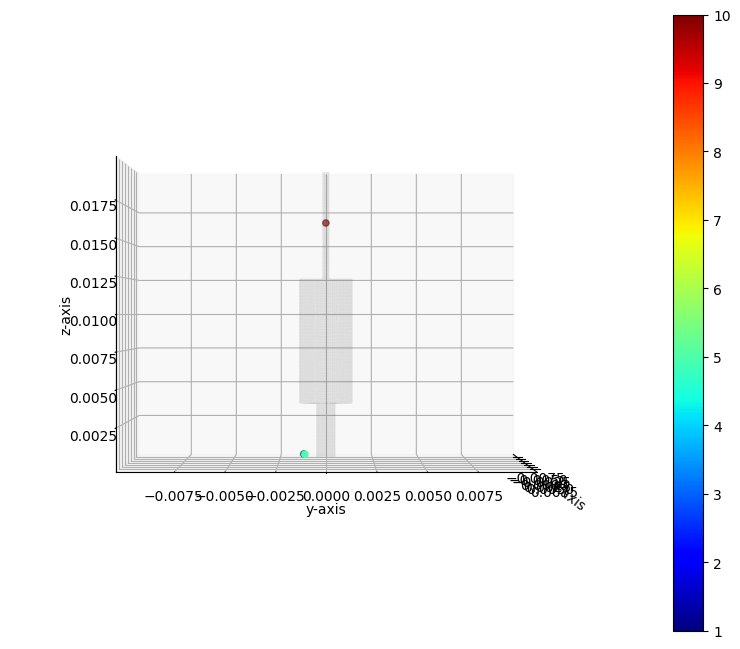

In [25]:
colormap = plt.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=0, vmax=np.max(array_c))

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection = '3d')


ax_scatter_obj = ax.scatter(array_x, array_y, array_z, s = 20, c = array_c, cmap = colormap)
fig.colorbar(ax_scatter_obj)



# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces]+cube_offset,alpha=0.1, facecolors='gray')
# mesh.set_edgecolor('')
# https://qiita.com/taiko1/items/23379266c1aaa2e67acc

ax.add_collection3d(mesh)

ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() * 0.5

#軸スケール一定
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# 真正面から見るための視点を設定する
ax.view_init(elev = 0, azim = 0)# elevは仰角（上下の角度）、azimは方位角（左右の角度）


plt.show()